<a href="https://colab.research.google.com/github/Celinejxy/MonteCarlo/blob/main/QuantDs_DPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
#!pip install yfinance

import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import random


**Get Data**

(currently Yahoo, I want Quandle)

In [19]:
# Define the tickers for the respective commodities on Yahoo Finance
tickers = {
    "gold": "GC=F",
    "silver": "SI=F",
    "palladium": "PA=F",
    "platinum": "PL=F",
    "copper": "HG=F"
}

# Define the start and end dates
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=10*365)).strftime('%Y-%m-%d')

# Define a function to fetch and save data
def fetch_and_save_data(ticker, commodity_name):
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')
    df.to_csv(f"{commodity_name}_last_10_years.csv")
    return df

# Dictionary to store all dataframes (useful for backtesting)
dataframes = {}

for commodity, ticker in tickers.items():
    dataframes[commodity] = fetch_and_save_data(ticker, commodity)

print("Data extraction and saving completed!")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Data extraction and saving completed!


**Backtesting Crossover Moving Average trading strategy**

(need to discuss with SME what data and strategy is most compatible to test)

In [40]:
def annualised_sharpe(returns, N=252):
    return np.sqrt(N) * (returns.mean() / returns.std())

In [41]:

def backtest_ma_crossover(dataframe, short_window=50, long_window=200):
    signals = pd.DataFrame(index=dataframe.index)
    signals["price"] = dataframe["Close"]

    # Compute short and long moving averages
    signals["short_mavg"] = dataframe["Close"].rolling(window=short_window, min_periods=1, center=False).mean()
    signals["long_mavg"] = dataframe["Close"].rolling(window=long_window, min_periods=1, center=False).mean()

    # Create signals
    signals["signal"] = 0.0
    signals["signal"][short_window:] = np.where(signals["short_mavg"][short_window:] > signals["long_mavg"][short_window:], 1.0, 0.0)
    signals["positions"] = signals["signal"].diff()

    # Calculate daily market log returns and strategy daily log returns
    signals['Market Returns'] = np.log(dataframe['Close'] / dataframe['Close'].shift(1))
    signals['Strategy'] = signals['Market Returns'] * signals['positions'].shift(1)

    # Cumulative Returns & generate equity curve
    signals['Strategy Equity'] = signals['Strategy'].cumsum()

    # Calculate Sharpe Ratio

    #try except to escape div by zero
    try:
        sharpe_ratio = annualised_sharpe(signals['Strategy'])
    except ZeroDivisionError:
        sharpe_ratio = 0

    return signals, sharpe_ratio

In [44]:
# Dictionary to store all signals and metrics for each commodity
signals_dict = {}
sharpe_ratios = {}

for commodity, dataframe in dataframes.items():
    signals_dict[commodity], sharpe_ratios[commodity] = backtest_ma_crossover(dataframe)

print("Backtesting completed!")
print("Sharpe Ratios:", sharpe_ratios)


Backtesting completed!
Sharpe Ratios: {'gold': 0.20799613599427405, 'silver': -0.16884637145049533, 'palladium': -0.3387528665745288, 'platinum': -0.11525775377645728, 'copper': 0.44301833937456636}


In [45]:
def plot_backtest_results(dataframe, signals, sharpe_ratio, commodity_name):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    # Plot Commodity Price, Short MA, and Long MA
    ax1.plot(dataframe.index, dataframe["Close"], 'r', label='Price')
    ax1.plot(dataframe.index, signals["short_mavg"], 'b', label='Short MA')
    ax1.plot(dataframe.index, signals["long_mavg"], 'g', label='Long MA')
    ax1.set_title(f"{commodity_name} Price and Moving Averages")
    ax1.set_ylabel("Price")
    ax1.legend(loc='best')

    # Plot buy/sell signals
    ax1.plot(signals[signals["positions"] == 1].index, signals["short_mavg"][signals["positions"] == 1], '^', markersize=10, color='m', label='buy')
    ax1.plot(signals[signals["positions"] == -1].index, signals["short_mavg"][signals["positions"] == -1], 'v', markersize=10, color='k', label='sell')

    # Plot Portfolio Equity Over Time
    ax2.plot(signals.index, signals["Strategy Equity"], 'b', label='Strategy Equity')
    ax2.set_title(f"{commodity_name} Portfolio Equity Over Time")
    ax2.set_ylabel("Cumulative Returns")
    ax2.legend(loc='best')

    plt.tight_layout()
    plt.show()

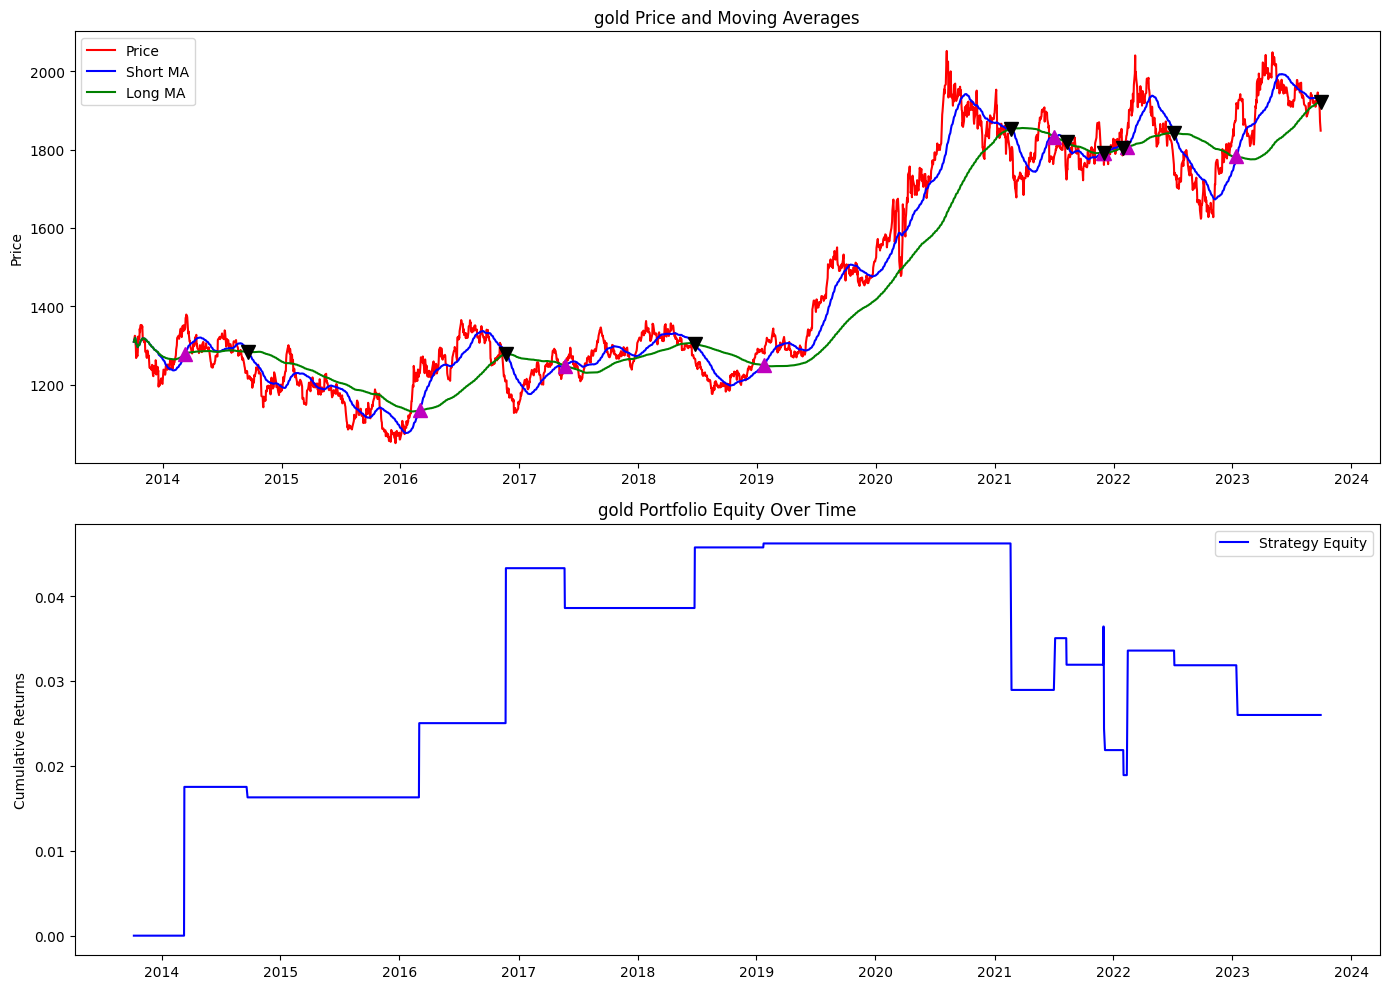

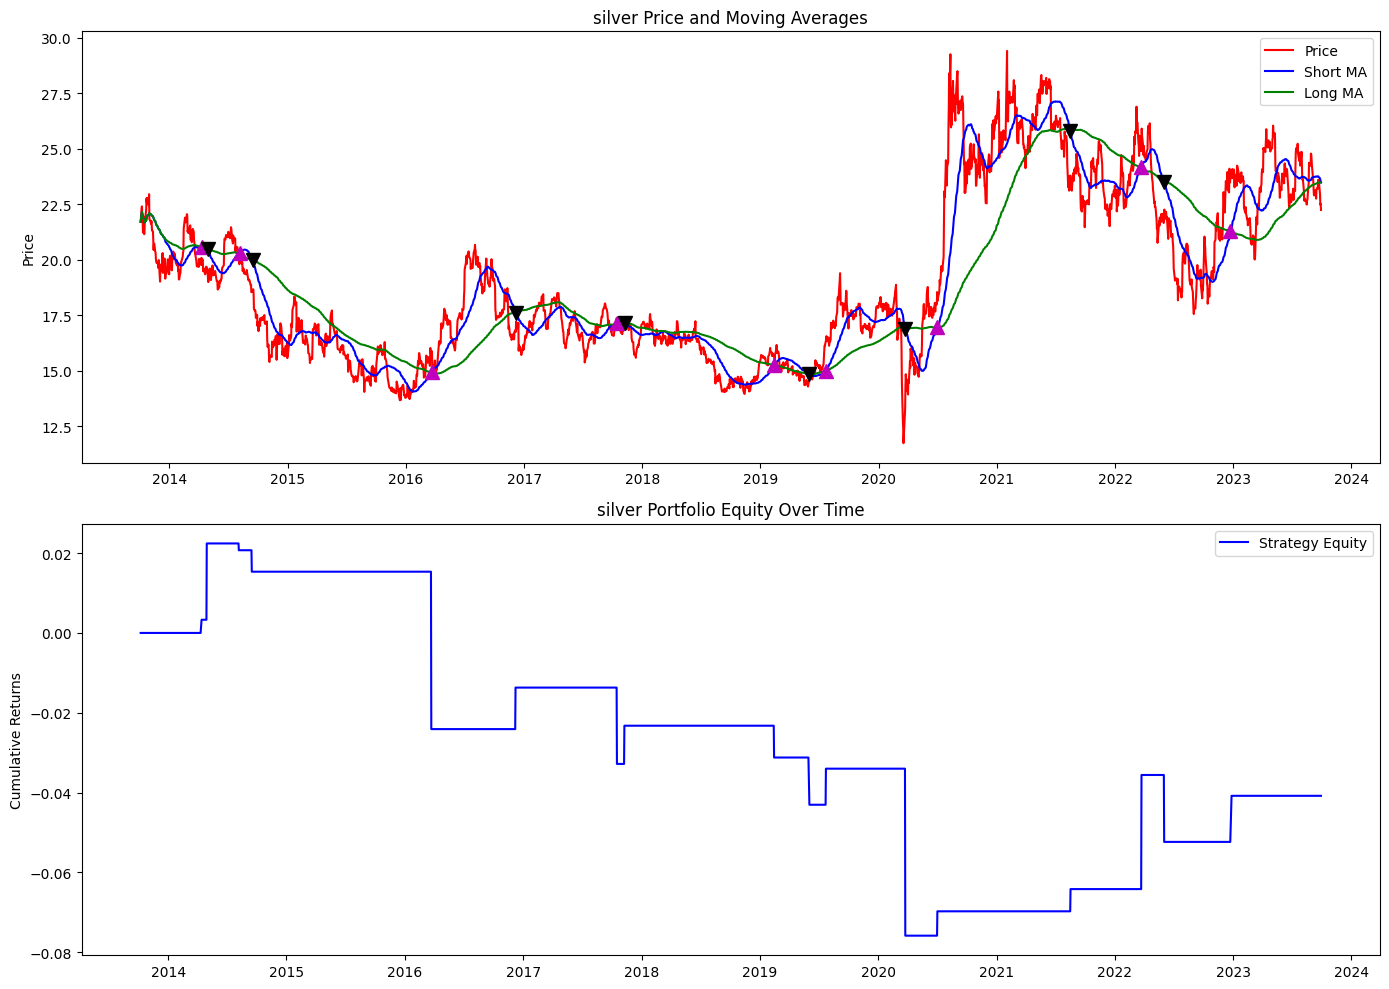

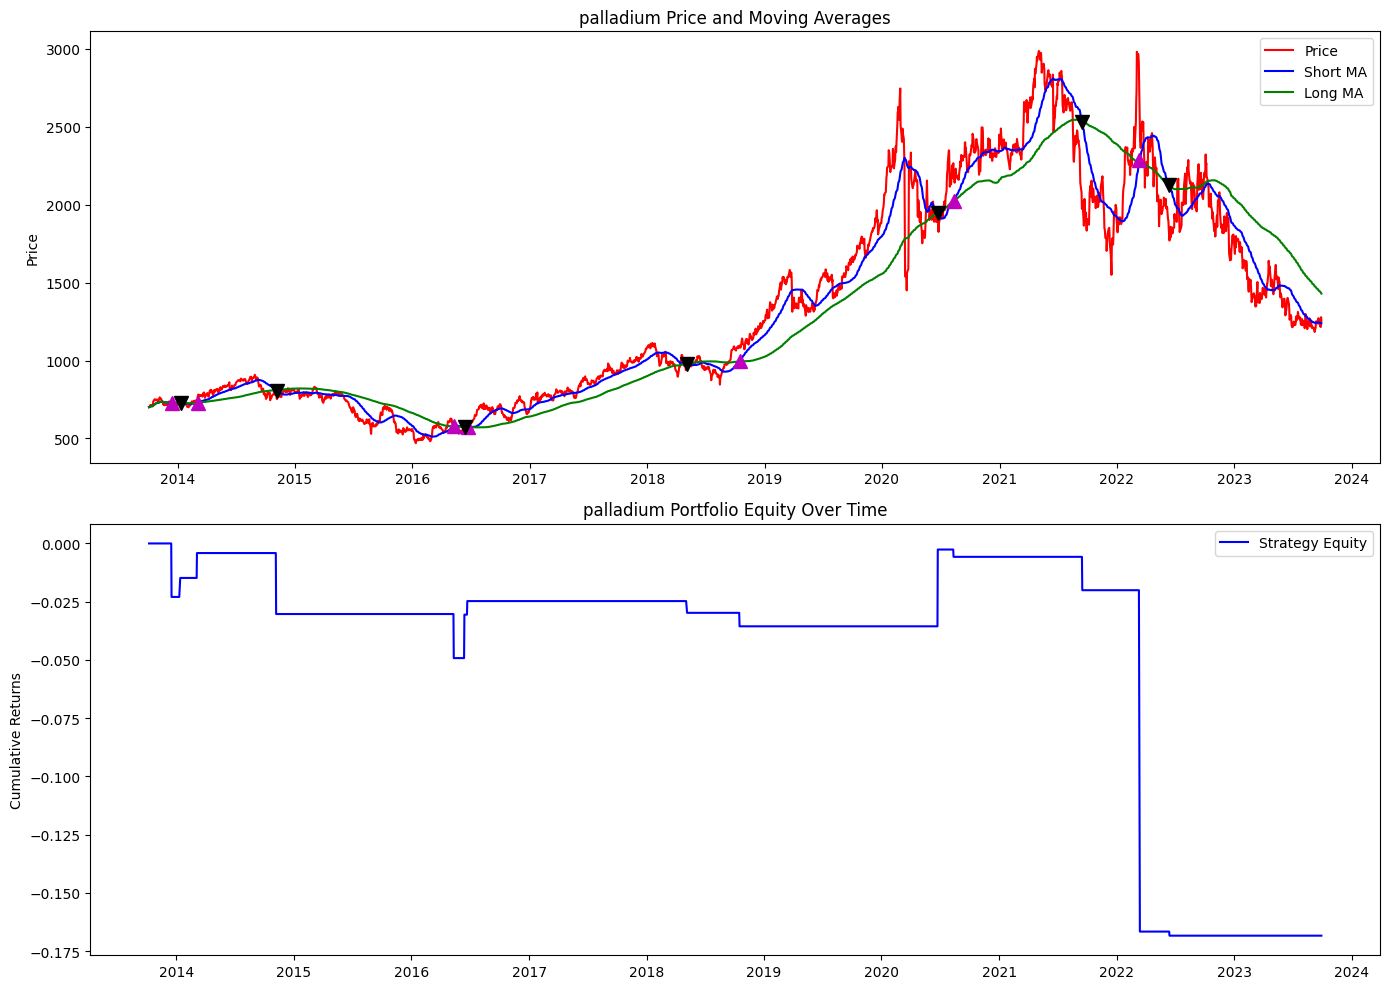

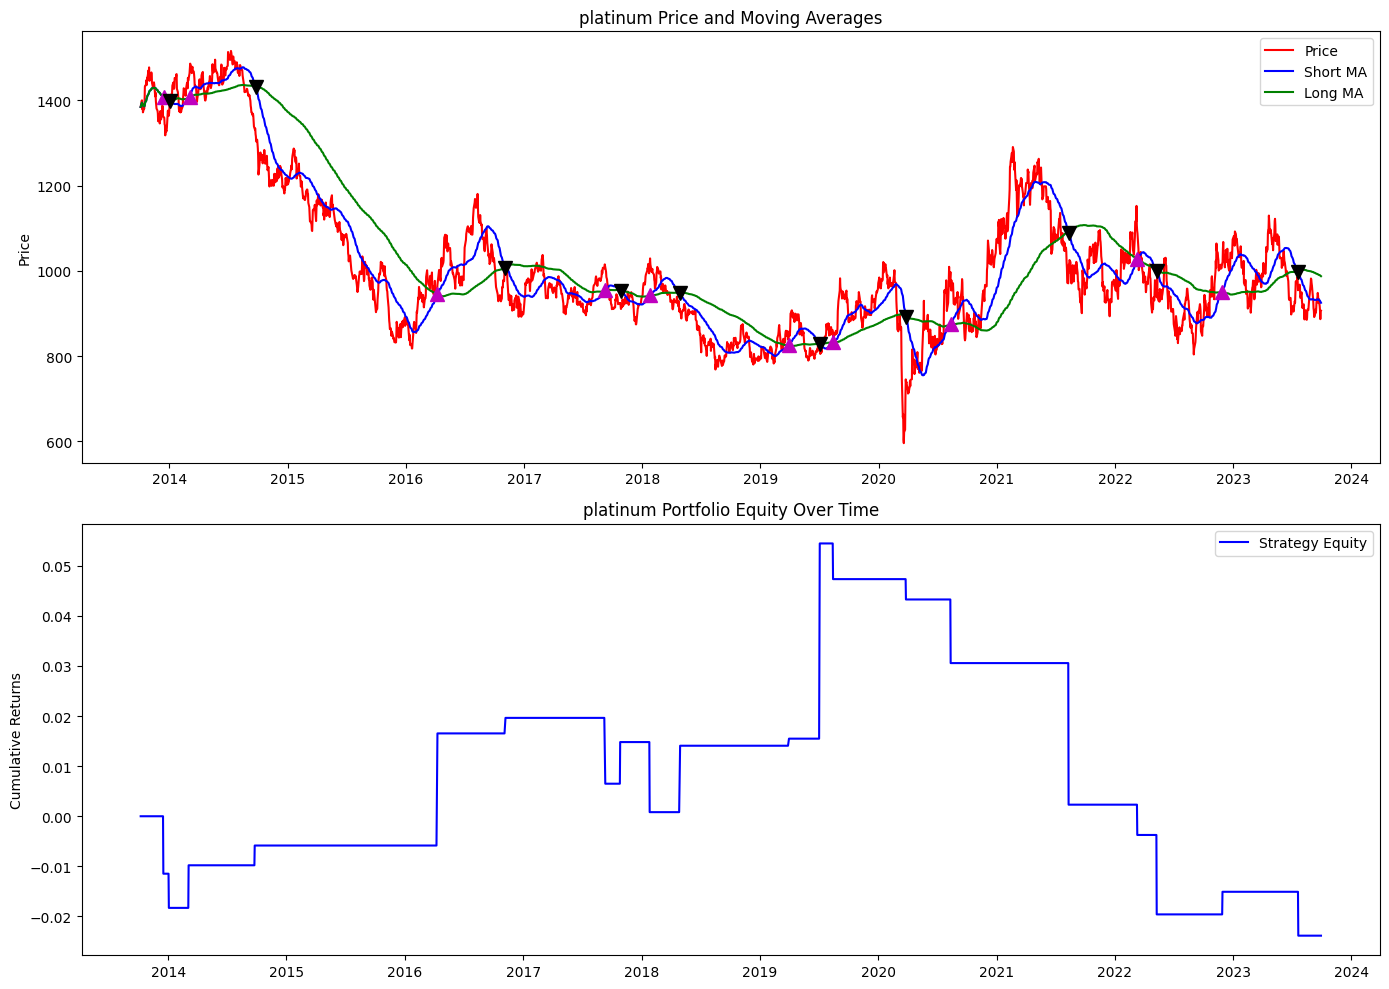

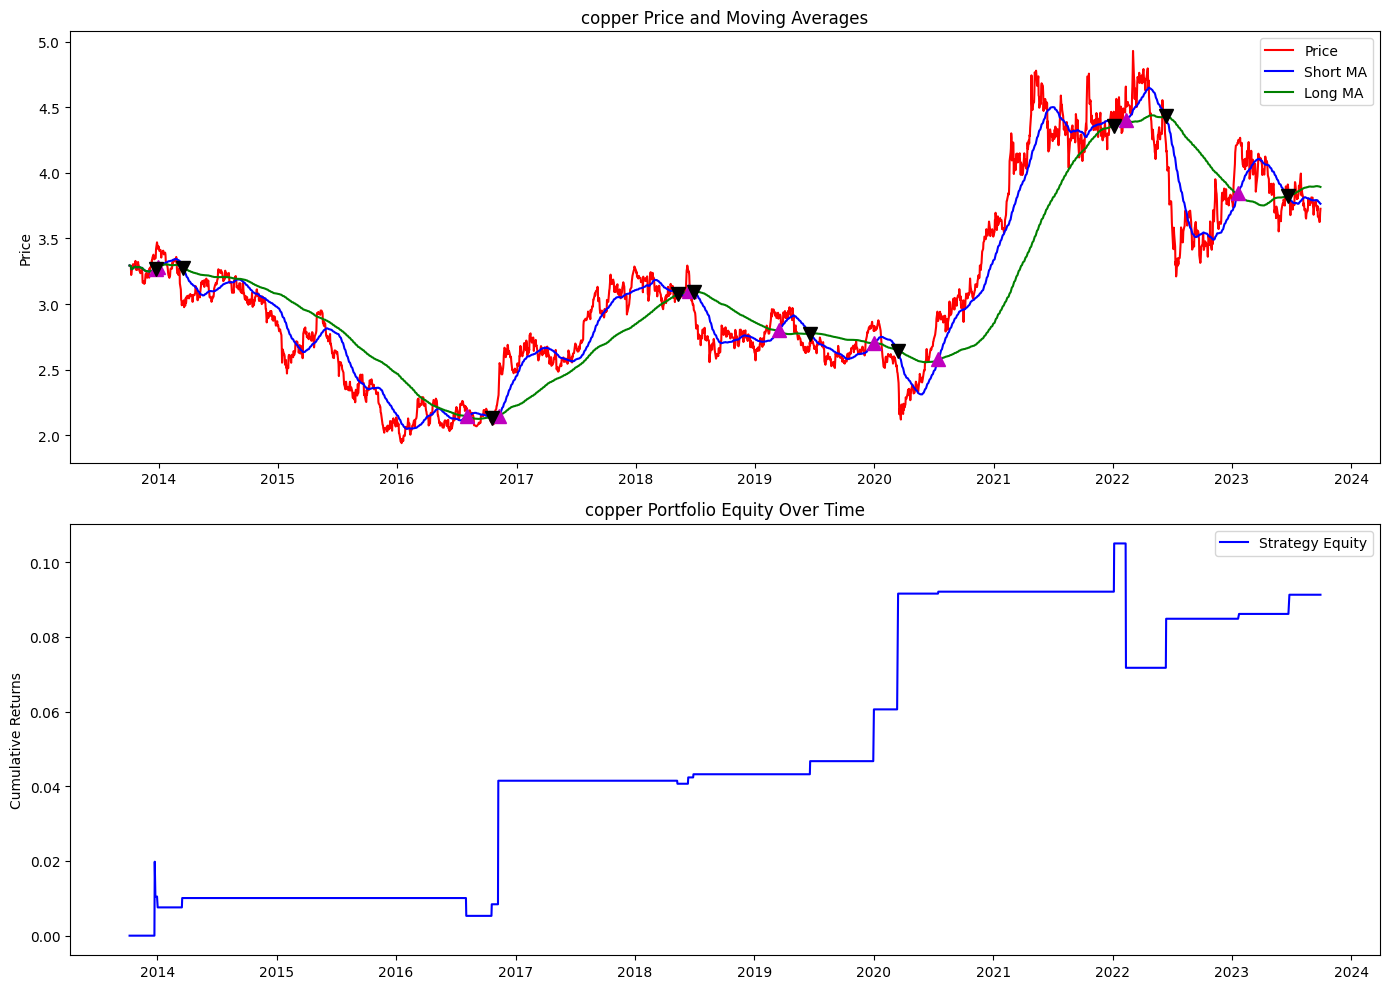

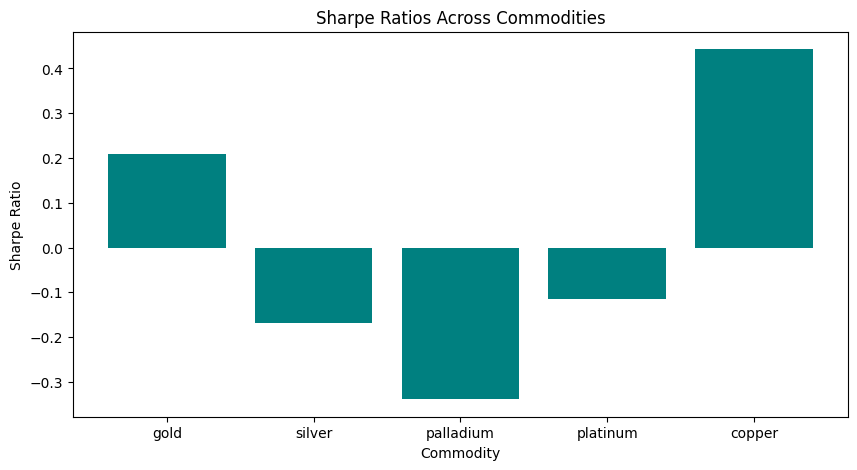

In [46]:
# Plot results for each commodity
for commodity, dataframe in dataframes.items():
    plot_backtest_results(dataframe, signals_dict[commodity], sharpe_ratios[commodity], commodity)

# Plot Sharpe Ratios
plt.figure(figsize=(10, 5))
plt.bar(sharpe_ratios.keys(), sharpe_ratios.values(), color='teal')
plt.title('Sharpe Ratios Across Commodities')
plt.ylabel('Sharpe Ratio')
plt.xlabel('Commodity')
plt.show()

**Monte Carlo Simulations of the commodities**


In [56]:
def monte_carlo_strategy_simulation(data, short_window, long_window, iters=1000):
    signals, sharpe_ratio = backtest_ma_crossover(data, short_window, long_window)
    mu = signals['Strategy'].mean()
    sigma = signals['Strategy'].std()

    days = 252
    mc_results = []
    mc_results_final_val = []

    for _ in range(iters):
        daily_returns = np.random.normal(mu, sigma, days) + 1
        equity_curve = [1]
        for ret in daily_returns:
            equity_curve.append(equity_curve[-1] * ret)
        mc_results.append(equity_curve)
        mc_results_final_val.append(equity_curve[-1])

    return mc_results, mc_results_final_val, sharpe_ratio


In [57]:
def plot_monte_carlo_simulation(mc_results, commodity_name):
    plt.figure(figsize=(14, 5))
    for path in mc_results:
        plt.plot(path, 'b-', lw=0.2)
    plt.title(f"Monte Carlo Simulation of Strategy for {commodity_name}")
    plt.xlabel("Days")
    plt.ylabel("Equity Curve")
    plt.show()


In [58]:
def evaluate_simulation(mc_results_final_val, sharpe_ratio):
    metrics = {
        "Mean": np.mean(mc_results_final_val),
        "Standard Deviation": np.std(mc_results_final_val),
        "5th Percentile": np.percentile(mc_results_final_val, 5),
        "Median": np.median(mc_results_final_val),
        "95th Percentile": np.percentile(mc_results_final_val, 95),
        "Sharpe Ratio": sharpe_ratio
    }
    return metrics

evaluation_data = {}


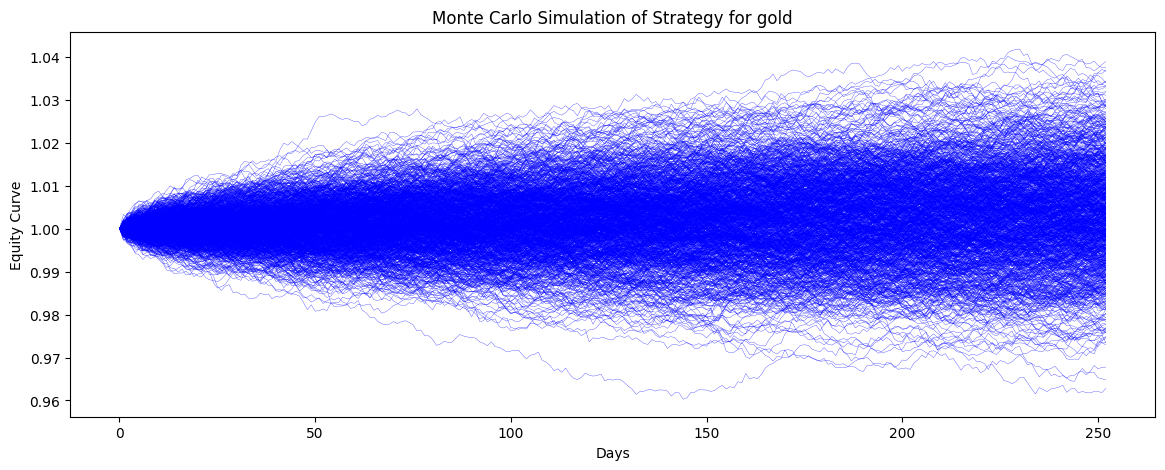

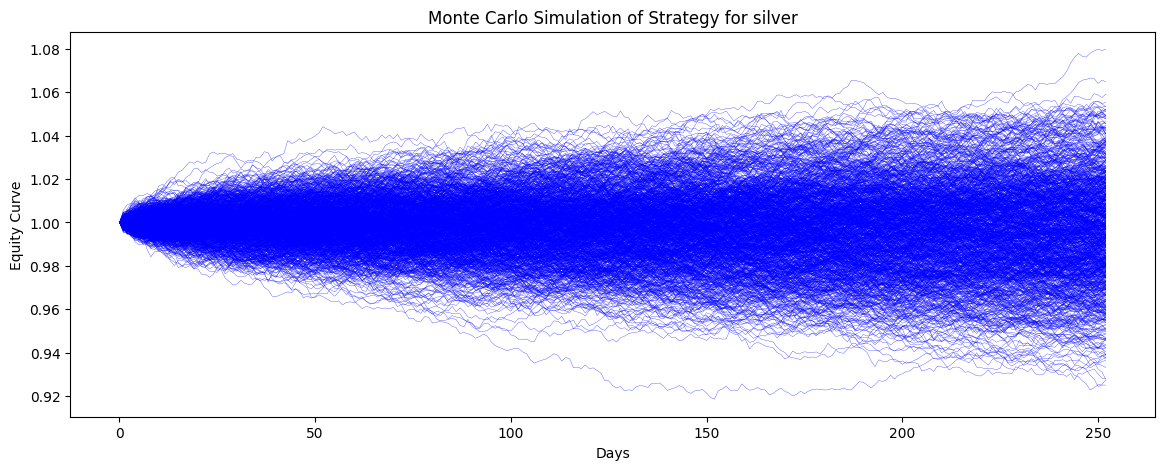

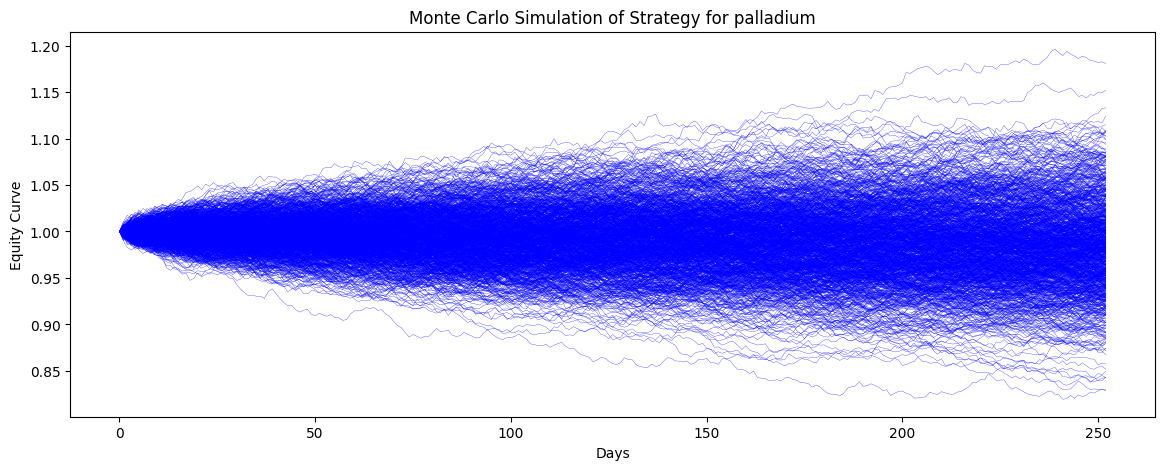

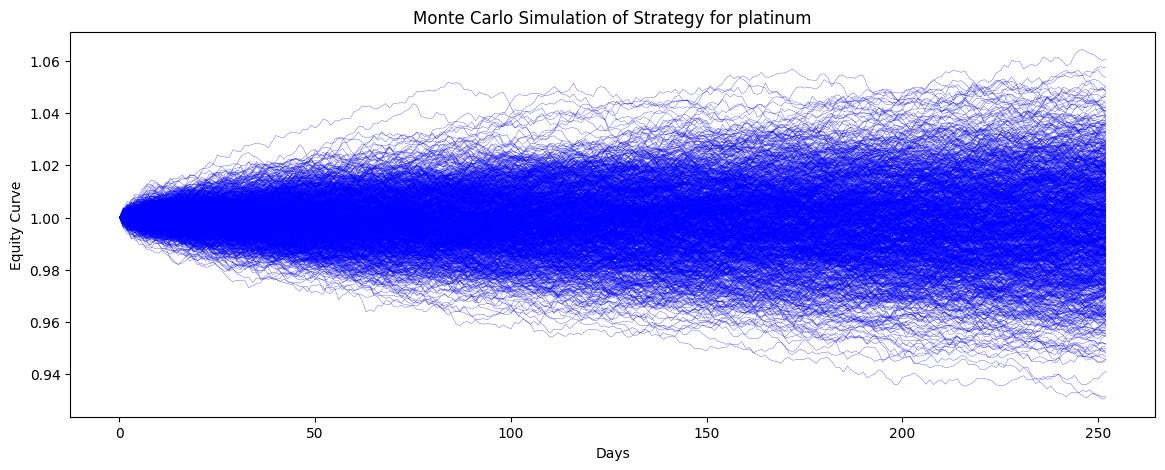

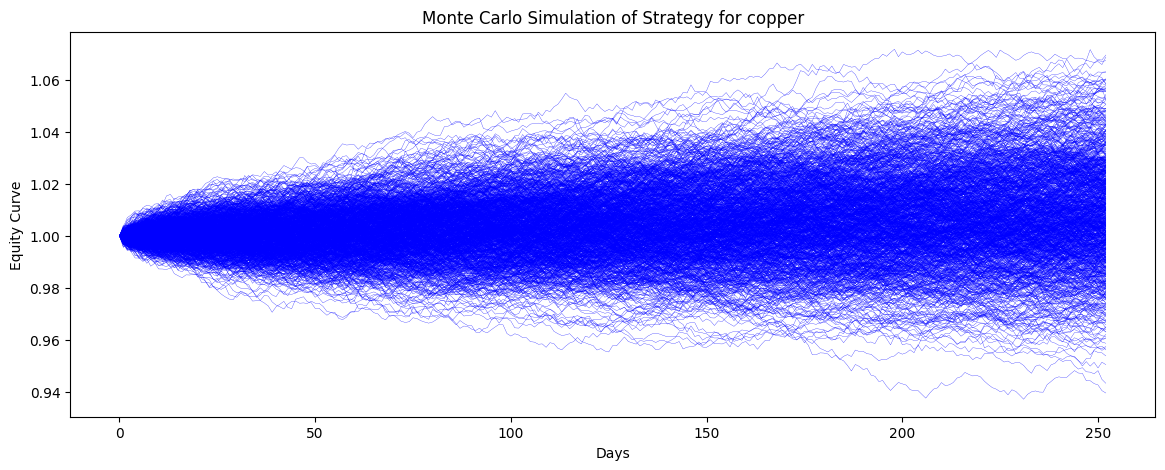

               Mean  Standard Deviation  5th Percentile    Median  \
gold       1.003375            0.012150        0.984138  1.003205   
silver     0.996208            0.024685        0.955438  0.996795   
palladium  0.984174            0.049601        0.909266  0.982600   
platinum   0.997654            0.020890        0.962988  0.997624   
copper     1.008915            0.020886        0.975469  1.008424   

           95th Percentile  Sharpe Ratio  
gold              1.024211      0.207996  
silver            1.037237     -0.168846  
palladium         1.071339     -0.338753  
platinum          1.031860     -0.115258  
copper            1.044356      0.443018  


In [59]:
for commodity, dataframe in dataframes.items():
    short_window = 50
    long_window = 200
    iters = 1000
    mc_results, mc_results_final_val, sharpe_ratio = monte_carlo_strategy_simulation(dataframe, short_window, long_window, iters)

    plot_monte_carlo_simulation(mc_results, commodity)
    evaluation_data[commodity] = evaluate_simulation(mc_results_final_val, sharpe_ratio)

evaluation_table = pd.DataFrame(evaluation_data).T
print(evaluation_table)

**Portfolio Optimizer**

(currently hill climb)

In [67]:
def portfolio_return_sharpe(dataframes, weights):
    total_return = 0
    for commodity, dataframe in dataframes.items():
        _, sharpe_ratio = backtest_ma_crossover(dataframe, 50, 200)
        total_return += sharpe_ratio * weights[commodity]
    return total_return

In [75]:
def portfolio_return_dollar(dataframes, weights):
    total_return = 0
    for commodity, dataframe in dataframes.items():
        signals, _ = backtest_ma_crossover(dataframe, 50, 200)
        cumulative_return = signals['Strategy'].cumsum().iloc[-1]  # Get the final cumulative return
        total_return += cumulative_return * weights[commodity]
    return total_return # Convert to percentage


In [78]:
def optimize_weights(dataframes, iterations=100):
    commodities = list(dataframes.keys())
    num_assets = len(commodities)

    # Initialize equal weights and best metrics
    best_weights = {commodity: 1/num_assets for commodity in commodities}
    best_sharpe = portfolio_return_sharpe(dataframes, best_weights)
    best_dollar = portfolio_return_dollar(dataframes, best_weights)

    for _ in range(iterations):
        # Tweak weights
        tweaked_weights = best_weights.copy()
        tweak_commodity = random.choice(commodities)
        tweak_amount = random.uniform(-0.05, 0.05)
        tweaked_weights[tweak_commodity] += tweak_amount

        # Ensure weights sum to 1
        adjust_commodity = random.choice([c for c in commodities if c != tweak_commodity])
        tweaked_weights[adjust_commodity] -= tweak_amount

        # Calculate Sharpe and dollar returns with tweaked weights
        tweaked_sharpe = portfolio_return_sharpe(dataframes, tweaked_weights)
        tweaked_dollar = portfolio_return_dollar(dataframes, tweaked_weights)

        # Compare & decide whether to update best weights
        if tweaked_sharpe > best_sharpe:
            best_weights = tweaked_weights
            best_sharpe = tweaked_sharpe
            best_dollar = tweaked_dollar

    # Calculate returns with initial weights
    initial_sharpe = portfolio_return_sharpe(dataframes, {commodity: 1/num_assets for commodity in commodities})
    initial_dollar = portfolio_return_dollar(dataframes, {commodity: 1/num_assets for commodity in commodities})

    return best_weights, (initial_sharpe, initial_dollar*100), (best_sharpe, best_dollar*100)



In [79]:
optimized_weights, initial_returns, optimized_returns = optimize_weights(dataframes, iterations=100)
print("Initial Returns (Sharpe, Dollar):", initial_returns)
print("Optimized Weights:", optimized_weights)
print("Optimized Returns (Sharpe, Dollar):", optimized_returns)


Initial Returns (Sharpe, Dollar): (0.005631496713471795, -2.314913647674252)
Optimized Weights: {'gold': 0.38086691915020543, 'silver': -0.010793299503252612, 'palladium': -0.23760864674064103, 'platinum': -0.1016242217569675, 'copper': 0.9691592488506557}
Optimized Returns (Sharpe, Dollar): (0.602600167718984, 14.122424630447302)


**APPENDIX**

In [ ]:
#pip install quandl pandas

In [36]:
#function to calculate Sharpe Ratio - Risk free rate element excluded for simplicity
def annualised_sharpe(returns, N=252):
    return np.sqrt(N) * (returns.mean() / returns.std())

def ma_strat(data,short_ma,long_ma):
    #create columns with MA values
    data['short_ma'] = np.round(data['Close'].rolling(window=short_ma).mean(),2)
    data['long_ma'] = np.round(data['Close'].rolling(window=long_ma).mean(),2)
    #create column with moving average spread differential
    data['short_ma-long_ma'] = data['short_ma'] - data['long_ma']
    #set desired number of points as threshold for spread difference and create column containing strategy 'Stance'
    X = 5
    data['Stance'] = np.where(data['short_ma-long_ma'] > X, 1, 0)
    data['Stance'] = np.where(data['short_ma-long_ma'] < -X, -1, data['Stance'])
    data['Stance'].value_counts()
    #create columns containing daily market log returns and strategy daily log returns
    data['Market Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    data['Strategy'] = data['Market Returns'] * data['Stance'].shift(1)
    #set strategy starting equity to 1 (i.e. 100%) and generate equity curve
    data['Strategy Equity'] = data['Strategy'].cumsum()
    #calculate Sharpe Ratio
    #try/except to escape case of division by zero
    try:
        sharpe = annualised_sharpe(data['Strategy'])
    except:
        sharpe = 0
    return data['Strategy'].cumsum(), sharpe, data['Strategy'].mean(), data['Strategy'].std()

In [ ]:
import quandl
import pandas as pd
from datetime import datetime, timedelta

# Set up the Quandl API key
quandl.ApiConfig.api_key = 'gdYyP6VcN9qP56joTKxV'  # Replace 'YOUR_QUANDL_API_KEY' with your actual API key

# Note: The Quandl database codes for commodities may differ from the ones provided here.
# Please refer to Quandl's documentation or website to get the accurate database codes.
# The example codes below might not be accurate.
tickers = {
    "gold": "CHRIS/CME_GC1",
    "silver": "CHRIS/CME_SI1",
    "copper": "CHRIS/CME_HG2"
}

# Define the start and end dates
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=60)).strftime('%Y-%m-%d')

# Define a function to fetch and save data
def fetch_and_save_data(ticker, commodity_name):
    df = quandl.get(ticker, start_date=start_date, end_date=end_date, collapse='30m')
    df.to_csv(f"{commodity_name}_last_60_days_30min.csv")
    return df

# Dictionary to store all dataframes (useful for backtesting)
dataframes = {}

for commodity, ticker in tickers.items():
    dataframes[commodity] = fetch_and_save_data(ticker, commodity)

print("Data extraction and saving completed!")
